In [1]:
import matplotlib.pyplot as plt
import numpy as np
from   numpy.linalg import inv
import numpy.random as npr
from   pypolyagamma import PyPolyaGamma
from scipy.stats import multivariate_normal

import matplotlib.cm as cm
from tqdm import tqdm
import polars as pl

import pandas as pd
import statsmodels.api as sm
import scipy
import scipy.optimize as opt
import seaborn as sns

from bayesian_statistics.utils_2 import *
import japanize_matplotlib

from keplergl import KeplerGl


In [2]:
from pathlib import Path

In [ ]:
data_dir = Path("../obsidian_data")

# Load the data
presence_cols = {
    'X座標': 'x', 
    'Y座標': 'y', 
    '遺跡_No':'ruin_number', 
    '標高': 'elevation', 
    '傾斜角度': 'slope_angle', 
    '傾斜方向': 'slope_direction',
    '至近河川からの累積コスト': 'distance_river', 
    '至近海岸線からの累積コスト': 'distance_coastline',
    '高原山からの累積コスト': 'distance_takahara',
    '神津島からの累積コスト': 'distance_kouzu',
    '信州からの累積コスト': 'distance_shinshu',
    '箱根からの累積コスト': 'distance_hakone',
    '河口からの累積コスト': 'distance_estuary'
}
presence_df = pd.read_csv(data_dir / "在データ.csv", index_col=None)
presence_df = presence_df.rename(columns=presence_cols)
presence_df.drop(columns=["Unnamed: 13"], inplace=True)

dtypes = {
    "x": float,
    "y": float,
    "ruin_number": int,
    "elevation": float,
    "slope_angle": float,
    "slope_direction": float,
    "distance_river": float,
    "distance_coastline": float,
    "distance_takahara": float,
    "distance_kouzu": float,
    "distance_shinshu": float,
    "distance_hakone": float,
    "distance_estuary": float
}

ruins = pd.read_csv(data_dir / "遺跡名と組成.csv", index_col=None)
ruins.rename(columns={"Unnamed: 0": "ruin_number"}, inplace=True)

ruins_dtypes = {
    "ruin_number": int,
    "Site": str,
    "Pr_C": int,
    "period_C": int,
    "phase_C": int,
    "Period": str,
    "Phase": str,
    "SHI": int,
    "KOZ": int,
    "HAK": int,
    "TAK": int,
    "UNK": int
}


name_dict = {
    "不在信州距離": "distance_shinshu",
    "不在傾斜方向": "slope_direction",
    "不在傾斜角度": "slope_angle",
    "不在標高": "elevation",
    "不在河口距離": "distance_estuary",
    "不在河川距離": "distance_river", 
    "不在海岸線距離": "distance_coastline",
    "不在神津距離": "distance_kouzu",
    "不在箱根距離": "distance_hakone",
    "不在高原距離": "distance_takahara",
}

df = pd.DataFrame(columns=["x", "y"])

for k, v in name_dict.items():
    tmp = pd.read_csv(data_dir / k, header=None)
    print(tmp.shape)
    tmp.columns = ["x", "y", v]
    df = df.merge(tmp, on=["x", "y"], how="outer")


absence_df = df.copy()

(432250, 3)
(427265, 3)
(419211, 3)
(432250, 3)
(432154, 3)
(408854, 3)
(431365, 3)
(432250, 3)
(432249, 3)
(431723, 3)


In [5]:
ruins

,ruin_number,Site,Pr_C,period_C,phase_C,Period,Phase,SHI,KOZ,HAK,TAK,UNK
0,74,Dosaka,1,4.0,2.0,Middle,Atamadai Ⅰb,0,10,0,0,0
1,74,Dosaka,1,4.0,2.0,Middle,Katsusaka 2,0,3,0,0,0
2,74,Dosaka,1,4.0,3.0,Middle,Kasori E2,0,4,0,0,0
3,74,Dosaka,1,4.0,3.0,Middle,katsusaka 3/Kasori E1,0,3,0,0,0
4,75,Ohashi,1,4.0,4.0,Middle,Kasori E3/4,324,49,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
294,133,Honosumiyoshi,8,4.0,3.0,Middle,Kasori E2,1,0,0,0,0
295,134,Miyatani,8,4.0,3.0,Middle,Kasori E2,2,0,0,0,0
296,135,Miyanomae,8,4.0,3.0,Middle,Sori Ⅱ,9,1,0,0,0
297,135,Miyanomae,8,4.0,4.0,Middle,Sori Ⅲ,8,2,0,0,0


In [6]:
presence_df

,x,y,ruin_number,elevation,slope_angle,slope_direction,distance_river,distance_coastline,distance_takahara,distance_kouzu,distance_shinshu,distance_hakone,distance_estuary
0,174125,174125,1,20.400000,0.883475,313.423462,8.590076,12.373066,150.583847,556.080200,887.733398,228.793900,12.753926
1,174625,152875,2,21.600000,0.536733,196.113419,9.749344,10.718177,163.754776,548.515869,881.725220,216.568970,10.471340
2,173875,149125,3,27.900000,1.064346,345.664581,2.063301,5.357552,157.300400,542.061401,875.270752,210.114594,5.155576
3,181375,147125,4,79.000000,0.663118,288.121887,23.698896,25.156948,184.320725,569.081970,902.291321,237.134918,25.993692
4,174375,162875,5,17.700001,1.357789,174.674271,6.772913,12.554237,164.194168,560.441650,893.651001,228.494720,13.374560
...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,174125,291625,236,311.200012,5.649503,327.466614,23.723684,199.261612,141.549301,727.863953,1625.918701,402.925140,199.225876
235,169875,286625,237,238.500000,2.517362,203.883102,8.461403,135.674972,95.945564,676.119141,1574.173828,351.180420,135.639252
236,179125,231875,238,44.299999,0.458500,181.432129,0.458500,44.491341,198.100525,637.578064,1549.453613,337.035126,43.454544
237,165375,211125,239,24.900000,1.260304,0.000000,2.158656,16.431477,137.241760,554.636963,890.984802,231.277954,16.812336


In [7]:
absence_df

,x,y,distance_shinshu,slope_direction,slope_angle,elevation,distance_estuary,distance_river,distance_coastline,distance_kouzu,distance_hakone,distance_takahara
0,125,64375,1114.468506,188.746155,0.753565,4.0,6.892451,6.180060,0.753565,400.770966,601.943726,862.275146
1,125,64625,1113.983032,170.909714,0.580225,6.5,6.406975,5.694584,1.333790,400.285492,601.458252,861.789673
2,125,64875,1113.794434,155.556046,0.276921,9.0,6.218375,5.505984,1.411538,400.096893,601.269653,861.601074
3,125,65125,1113.829346,333.434937,0.128117,8.7,6.253286,5.540895,1.539655,400.131775,601.304626,861.636047
4,125,65375,1114.235718,248.498566,0.406430,8.0,6.659716,5.947326,1.946085,400.538208,601.711060,862.042480
...,...,...,...,...,...,...,...,...,...,...,...,...
432245,229625,167625,907.326111,61.064186,3.217676,12.2,12.945311,12.851694,3.217676,577.102539,249.050308,158.143661
432246,229625,167875,907.480408,72.474426,2.282013,5.0,12.954888,12.861273,2.282013,577.256836,249.204575,158.297928
432247,229625,168125,906.956299,93.628548,2.352523,6.2,12.558356,12.464741,2.352523,576.732727,248.680359,157.773712
432248,229625,168375,906.870605,73.770790,2.540433,6.3,12.472681,12.379066,2.540433,576.646973,248.594696,157.688049


In [8]:
absence_df.x.min(), absence_df.x.max()

(125, 229625)

In [9]:
import geopandas as gpd
from shapely.geometry import Polygon

def create_bounding_box(min_lon, max_lon, min_lat, max_lat):
    """
    Create a rectangular polygon from given coordinates
    
    Parameters:
    min_lon: Minimum longitude (western boundary)
    max_lon: Maximum longitude (eastern boundary)
    min_lat: Minimum latitude (southern boundary)
    max_lat: Maximum latitude (northern boundary)
    
    Returns:
    GeoDataFrame containing the bounding box polygon
    """
    # Create coordinates for the polygon (counterclockwise)
    coordinates = [
        (min_lon, min_lat),  # Bottom left
        (max_lon, min_lat),  # Bottom right
        (max_lon, max_lat),  # Top right
        (min_lon, max_lat),  # Top left
        (min_lon, min_lat)   # Back to start to close the polygon
    ]
    
    # Create polygon
    polygon = Polygon(coordinates)
    
    # Create GeoDataFrame
    gdf = gpd.GeoDataFrame(
        {'name': ['関東地方の範囲']},
        geometry=[polygon],
        crs="EPSG:4326"
    )
    
    return gdf

# 指定された範囲でバウンディングボックスを作成
bounding_box = create_bounding_box(
    min_lon=138.0,
    max_lon=141.0,
    min_lat=34.0,
    max_lat=37.0
)

In [10]:
from keplergl import KeplerGl
_map = KeplerGl(height=800)
_map.add_data(data=bounding_box, name='関東地方の範囲')
_map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'関東地方の範囲': {'index': [0], 'columns': ['name', 'geometry'], 'data': [['関東地方の範囲', 'POLYGON ((138.…

※角度単位は°　傾斜方向は-1が方向無し、時計回りに0～359.9999°										
※累積コストは累積傾斜角度に近似										
										
										
最大値	1053.900024	21.8946209	357.8886719	342.9176331	1153.96521	1844.156738	1832.280029	1722.395996	1571.28479	1153.6604
										
最大値を参考に、それ以下の範囲を抽出し、その範囲内を指定して全域サンプリング						
										
至近河川からの累積コスト	至近海岸線からの累積コスト	高原山からの累積コスト	神津島からの累積コスト	信州からの累積コスト	箱根からの累積コスト	河口からの累積コスト

/home/ohta/dev/bayesian_statistics/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


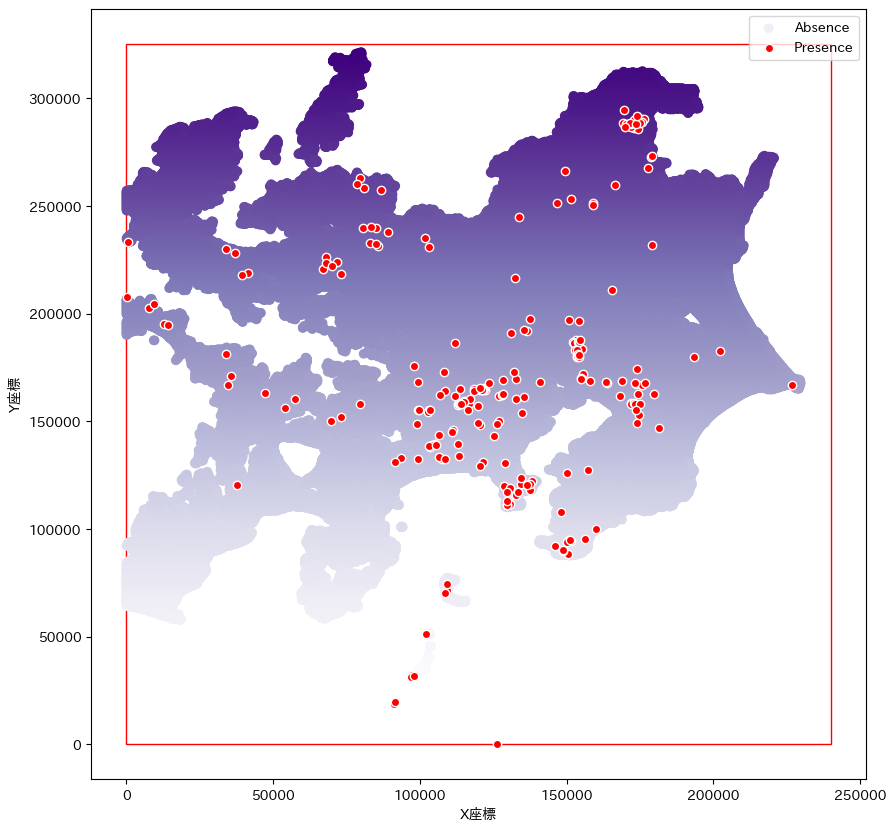

In [48]:
plt.figure(figsize=(10, 10))

# プロットする長方形の頂点を定義
rectangle = plt.Rectangle((0, 0), 240000, 325000, linewidth=1, edgecolor='r', facecolor='none')

# 現在のプロットに長方形を追加
plt.gca().add_patch(rectangle)

# absence_dfのデータをプロット
plt.scatter(absence_df["x"], absence_df["y"], c=absence_df["y"], cmap="Purples", label='Absence')

# presence_dfのデータをプロット
plt.scatter(presence_df["x"], presence_df["y"], c="red", edgecolors="white", label='Presence')

# ラベルと凡例を追加
plt.xlabel('X座標')
plt.ylabel('Y座標')
plt.legend()

plt.show()

In [49]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# データフレームを読み込みます（既に 'df' として存在すると仮定）
df = absence_df.copy()

# スケーリングファクターを計算します
longitude_scale = (141.0 - 138.0) / (240000.0)  # X方向の1メートルあたりの経度の増加量
latitude_scale = (37.0 - 34.0) / (325000.0)     # Y方向の1メートルあたりの緯度の増加量

# 座標を変換します
df['longitude'] = df['x'] * longitude_scale + 138.0
df['latitude'] = df['y'] * latitude_scale + 34.0

# ジオメトリを作成します
df['geometry'] = df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)

# GeoDataFrameを作成します
gdf = gpd.GeoDataFrame(df, geometry='geometry')

# 座標系を設定します
gdf.crs = 'EPSG:4326'

# 変換結果を確認します
print(gdf[['latitude', 'longitude', 'geometry']].head())


    latitude   longitude                    geometry
0  34.594231  138.001563  POINT (138.00156 34.59423)
1  34.596538  138.001563  POINT (138.00156 34.59654)
2  34.598846  138.001563  POINT (138.00156 34.59885)
3  34.601154  138.001563  POINT (138.00156 34.60115)
4  34.603462  138.001563  POINT (138.00156 34.60346)


In [50]:
gdf

,x,y,distance_shinshu,slope_direction,slope_angle,elevation,distance_estuary,distance_river,distance_coastline,distance_kouzu,distance_hakone,distance_takahara,longitude,latitude,geometry
0,125,64375,1114.468506,188.746155,0.753565,4.0,6.892451,6.180060,0.753565,400.770966,601.943726,862.275146,138.001563,34.594231,POINT (138.00156 34.59423)
1,125,64625,1113.983032,170.909714,0.580225,6.5,6.406975,5.694584,1.333790,400.285492,601.458252,861.789673,138.001563,34.596538,POINT (138.00156 34.59654)
2,125,64875,1113.794434,155.556046,0.276921,9.0,6.218375,5.505984,1.411538,400.096893,601.269653,861.601074,138.001563,34.598846,POINT (138.00156 34.59885)
3,125,65125,1113.829346,333.434937,0.128117,8.7,6.253286,5.540895,1.539655,400.131775,601.304626,861.636047,138.001563,34.601154,POINT (138.00156 34.60115)
4,125,65375,1114.235718,248.498566,0.406430,8.0,6.659716,5.947326,1.946085,400.538208,601.711060,862.042480,138.001563,34.603462,POINT (138.00156 34.60346)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
432245,229625,167625,907.326111,61.064186,3.217676,12.2,12.945311,12.851694,3.217676,577.102539,249.050308,158.143661,140.870313,35.547308,POINT (140.87031 35.54731)
432246,229625,167875,907.480408,72.474426,2.282013,5.0,12.954888,12.861273,2.282013,577.256836,249.204575,158.297928,140.870313,35.549615,POINT (140.87031 35.54962)
432247,229625,168125,906.956299,93.628548,2.352523,6.2,12.558356,12.464741,2.352523,576.732727,248.680359,157.773712,140.870313,35.551923,POINT (140.87031 35.55192)
432248,229625,168375,906.870605,73.770790,2.540433,6.3,12.472681,12.379066,2.540433,576.646973,248.594696,157.688049,140.870313,35.554231,POINT (140.87031 35.55423)


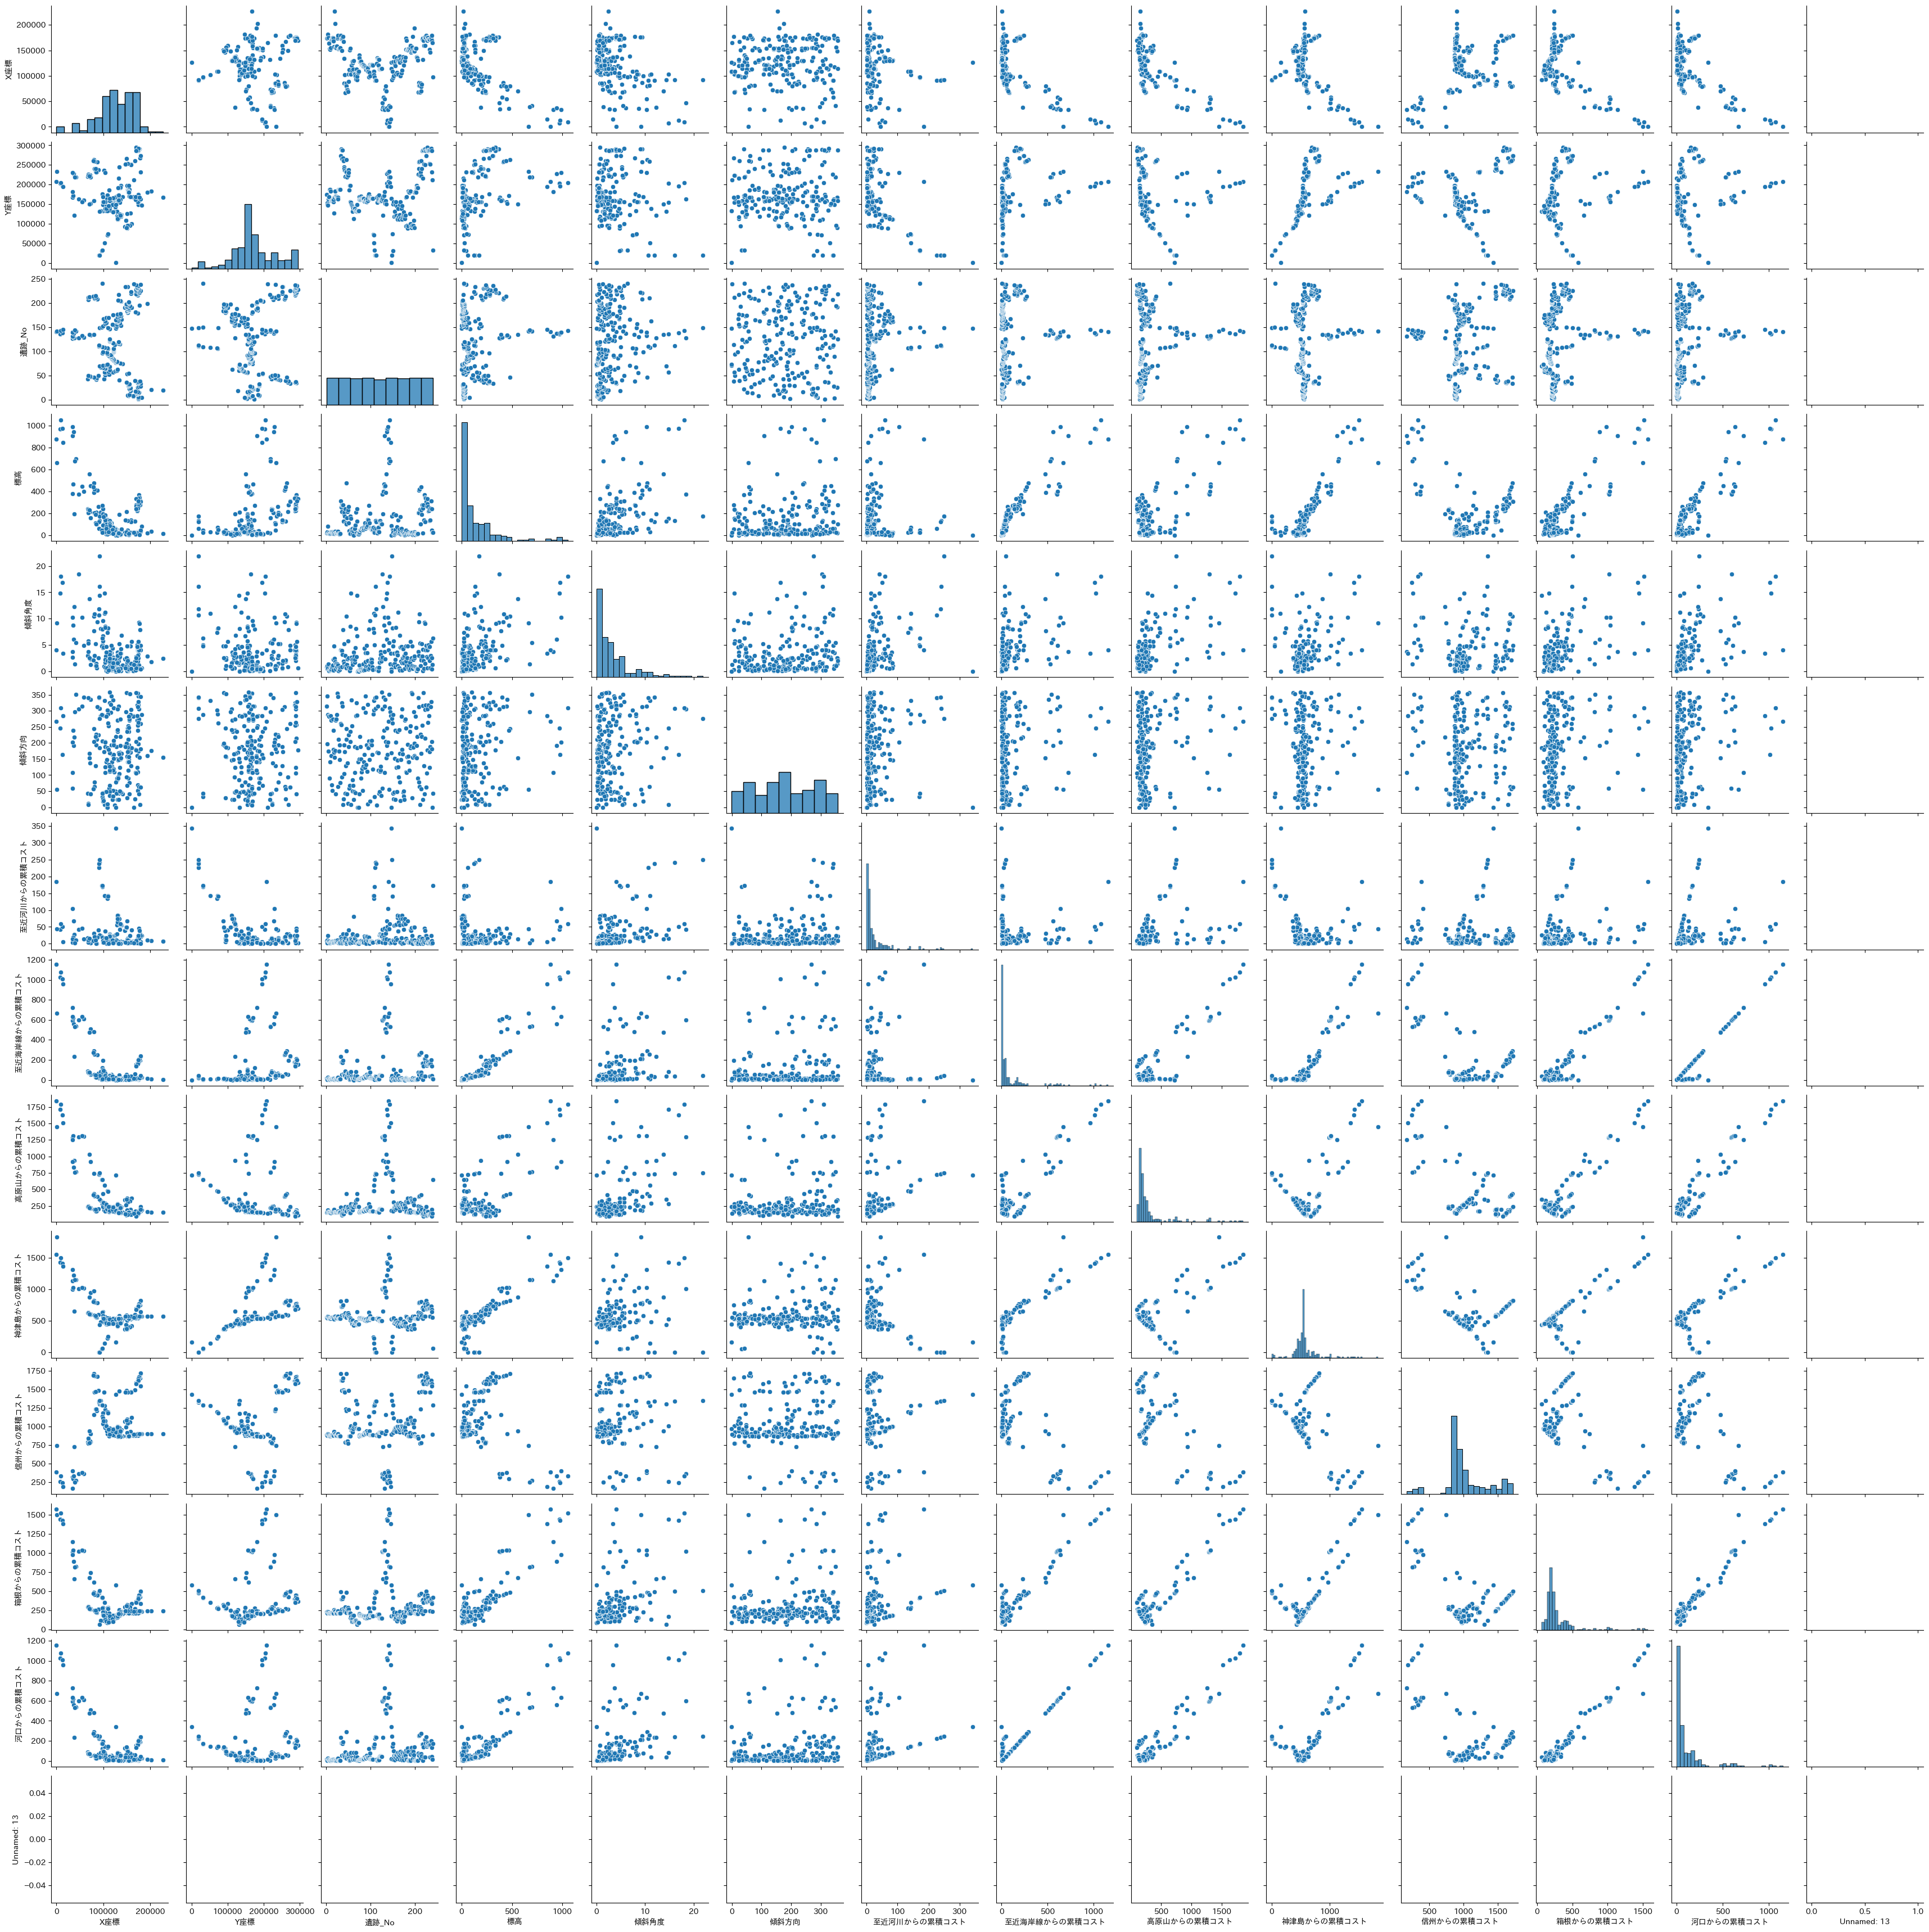

In [ ]:
sns.pairplot(presence_df)

In [50]:
ruins
#presence_df = presence_df.merge(ruins, left_on="ruin_number", right_index=True)

dtype('O')